In [6]:
#%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
matplotlib.rcParams['figure.figsize'] = [16*1., 9*1.]
import pandas as pd
import numpy as np
import cv2
import os
from PIL import Image

# Directory containing your images
image_dir = './documents'  # Current directory

# List all files in the directory
image_files = os.listdir(image_dir)

# Open each image file
images = [Image.open(os.path.join(image_dir, file)).convert('L') for file in image_files if file.endswith(('.png', '.jpg', '.jpeg'))]

In [7]:
height, width = 2, 3

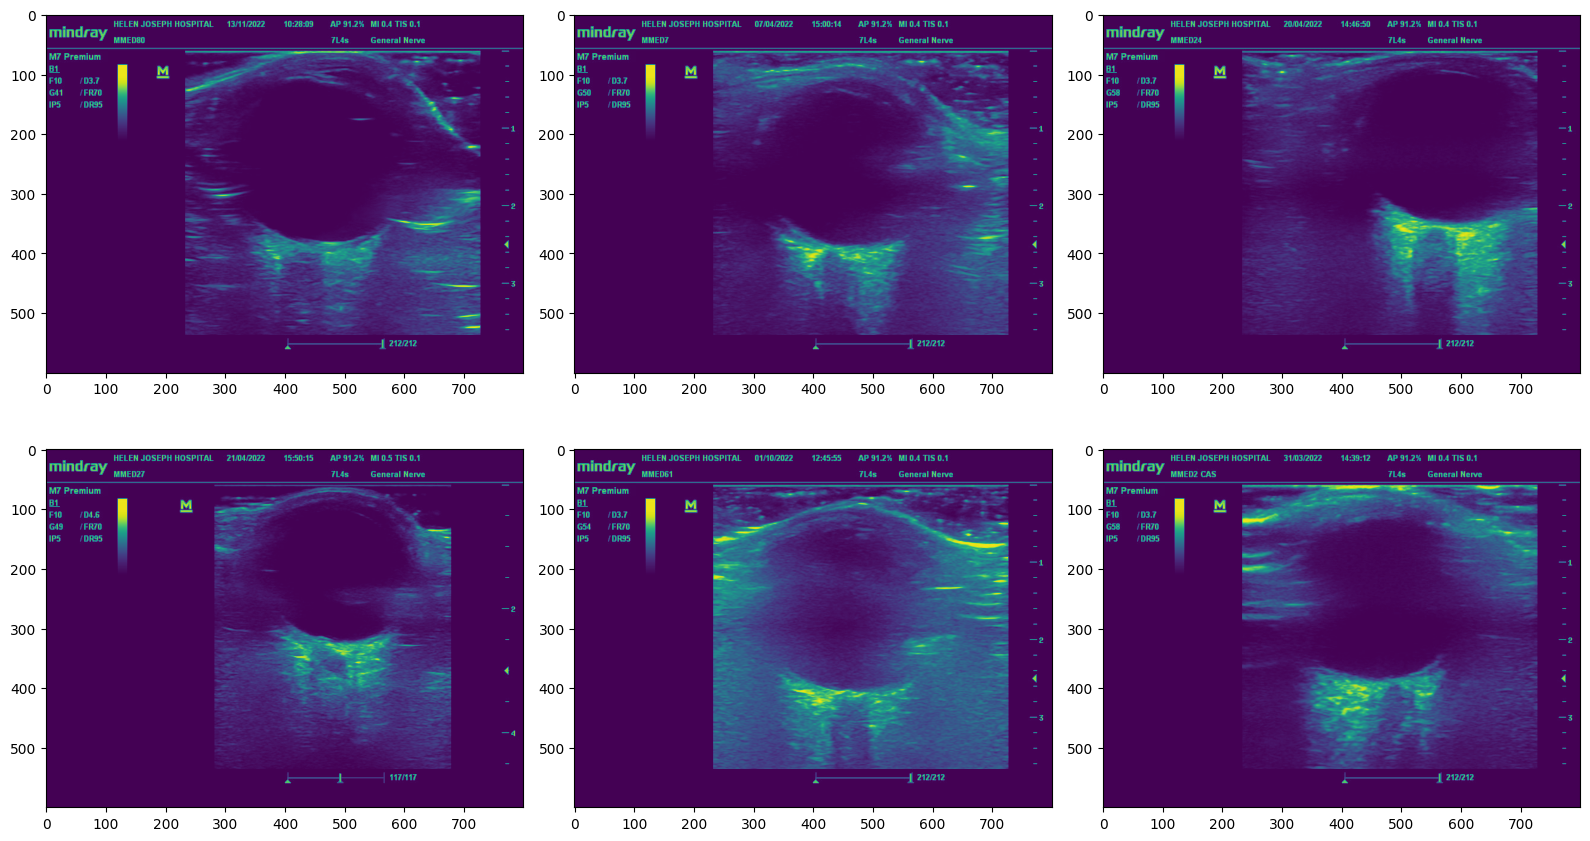

In [8]:
fig, ax = plt.subplots(height, width)
# Display the first images
for i in range(height * width):
    ax[i // width, i % width].imshow(images[i])

plt.tight_layout()

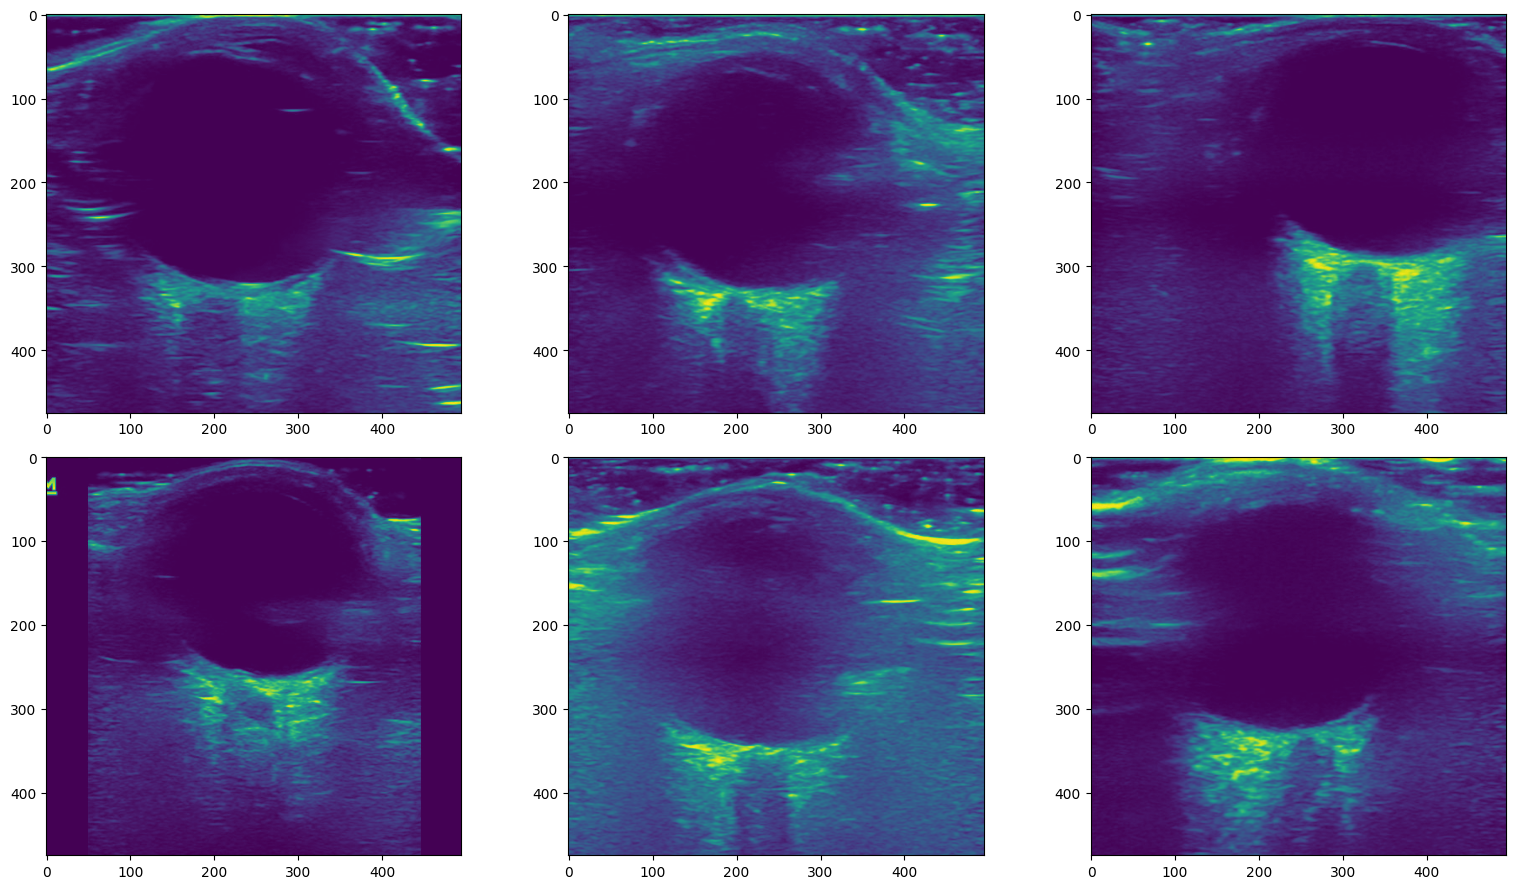

In [9]:
# Image field size:
left = 232
top = 60
img_width = 495
img_height = 475
right = left + img_width
bottom = top + img_height
cropped_images = [img.crop((left,top,right,bottom)) for img in images]

cv_images = [np.array(image) for image in cropped_images]

fig, ax = plt.subplots(height, width)
# Display the first images
for i in range(height * width):
    ax[i // width, i % width].imshow(cv_images[i])

plt.tight_layout()

In [10]:
MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15
MAX_DELTA = 200    # Maximum offset between images. This should be crop_left - crop_width on the left and respectively for each offset direction.
crop_top = 290
crop_height = 100
crop_bottom = crop_top + crop_height
crop_left = 215
crop_width = 125
crop_right = crop_left + crop_width
MIN_DELTA_X = -crop_left
MAX_DELTA_X = img_width - crop_right
MIN_DELTA_Y = -crop_top
MAX_DELTA_Y = img_height - crop_bottom
print(f"{crop_bottom=}, {img_height=}")
print(f"{MIN_DELTA_X=}, {MAX_DELTA_X=}, {MIN_DELTA_Y=}, {MAX_DELTA_Y=}")
print(f"{-crop_left=}, {200=}, {-crop_top=}, {80=}")

from sklearn.cluster import DBSCAN
#cluster_model = DBSCAN(eps=6, min_samples=5)
cluster_model = DBSCAN(eps=10, min_samples=5)

def alignImages(im1, im2):
  if len(im1.shape) == 3:
      # Convert images to grayscale
      im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
      im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
  else:
      im1Gray = im1
      im2Gray = im2
 
  # Detect ORB features and compute descriptors.
  orb = cv2.ORB_create(MAX_FEATURES)
  keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
  keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)
 
  # Match features.
  #matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
  matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_L1)
  matches = list(matcher.match(descriptors1, descriptors2, None))
 
  # Sort matches by score
  matches.sort(key=lambda x: x.distance, reverse=False)
 
  # Remove not so good matches
  numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
  matches = matches[:numGoodMatches]
 
  # Draw top matches
  match_image = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
 
  # Extract location of good matches
  points1 = np.zeros((len(matches), 2), dtype=np.float32)
  points2 = np.zeros((len(matches), 2), dtype=np.float32)

  deltas = np.zeros((len(matches), 2))    # x, y offset between points matched in both images
  for i, match in enumerate(matches):
      points1[i, :] = keypoints1[match.queryIdx].pt
      points2[i, :] = keypoints2[match.trainIdx].pt
      deltas[i] = points2[i] - points1[i]

  # Remove deltas larger than the image field
  deltas = deltas[np.where((deltas[:,0] > MIN_DELTA_X) & (deltas[:,0] < MAX_DELTA_X) & (deltas[:,1] > MIN_DELTA_Y) & (deltas[:,1] < MAX_DELTA_Y))]

  # Cluster feature offsets
  associations = cluster_model.fit_predict(deltas)
  clusters = np.unique(associations)
  cluster_points = np.where(associations == 0)    # Cluster #0 is the first cluster, #-1 is the unclustered points
  offset = np.average(deltas[cluster_points], axis=0)    # Return the most likely offset
  return offset, deltas, cluster_points, match_image
    
  assert len(points1) == len(points2)
  distances = np.zeros(len(matches))
  deltas_x, deltas_y = np.zeros(len(matches)), np.zeros(len(matches))
  sum_delta_x, sum_delta_y, sum_distance = 0, 0, 0
  for i, (point1, point2) in enumerate(zip(points1, points2)):
      deltas_x[i] = point2[0] - point1[0]
      deltas_y[i] = point2[1] - point1[1]
      distance = sqrt(deltas_x[i]**2 + deltas_y[i]**2)
      distances[i] = distance
      sum_delta_x += deltas_x[i]
      sum_delta_y += deltas_y[i]
      sum_distance += distances[i]
  avg_delta_x = sum_delta_x / len(points1)
  avg_delta_y = sum_delta_y / len(points1)
  avg_distance = sum_distance / len(points1)

  selection = (distances < 250)
  offset_left = np.average(deltas_x[selection])
  offset_top = np.average(deltas_y[selection])
  resid_x = deltas_x - offset_left
  resid_y = deltas_y - offset_top
  std_x = np.std(resid_x)
  std_y = np.std(resid_y)
  #print(std_x, std_y)
  selection = (distances < 100) & ((abs(resid_x) + abs(resid_y)) < 45)# & (deltas_y > 0)
  offset_left = np.average(deltas_x[selection])
  offset_top = np.average(deltas_y[selection])
  return (offset_left, offset_top, deltas, selection)

crop_bottom=390, img_height=475
MIN_DELTA_X=-215, MAX_DELTA_X=155, MIN_DELTA_Y=-290, MAX_DELTA_Y=85
-crop_left=-215, 200=200, -crop_top=-290, 80=80


[ 86.6931015  -67.22214661]
-1
0


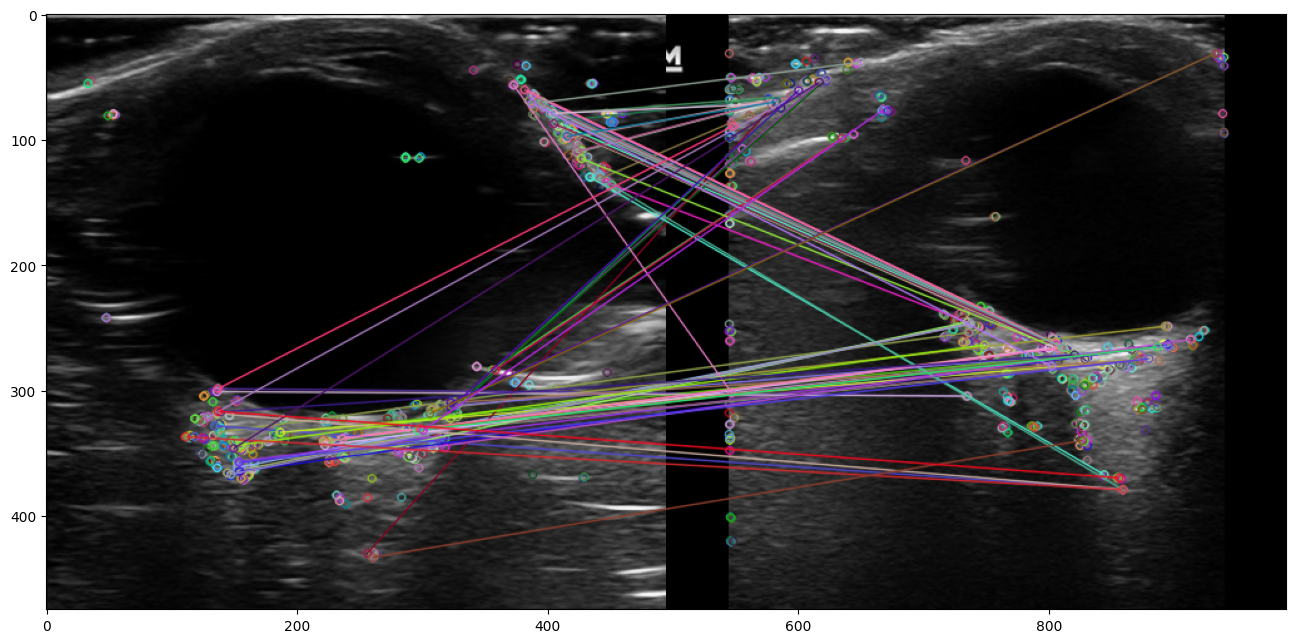

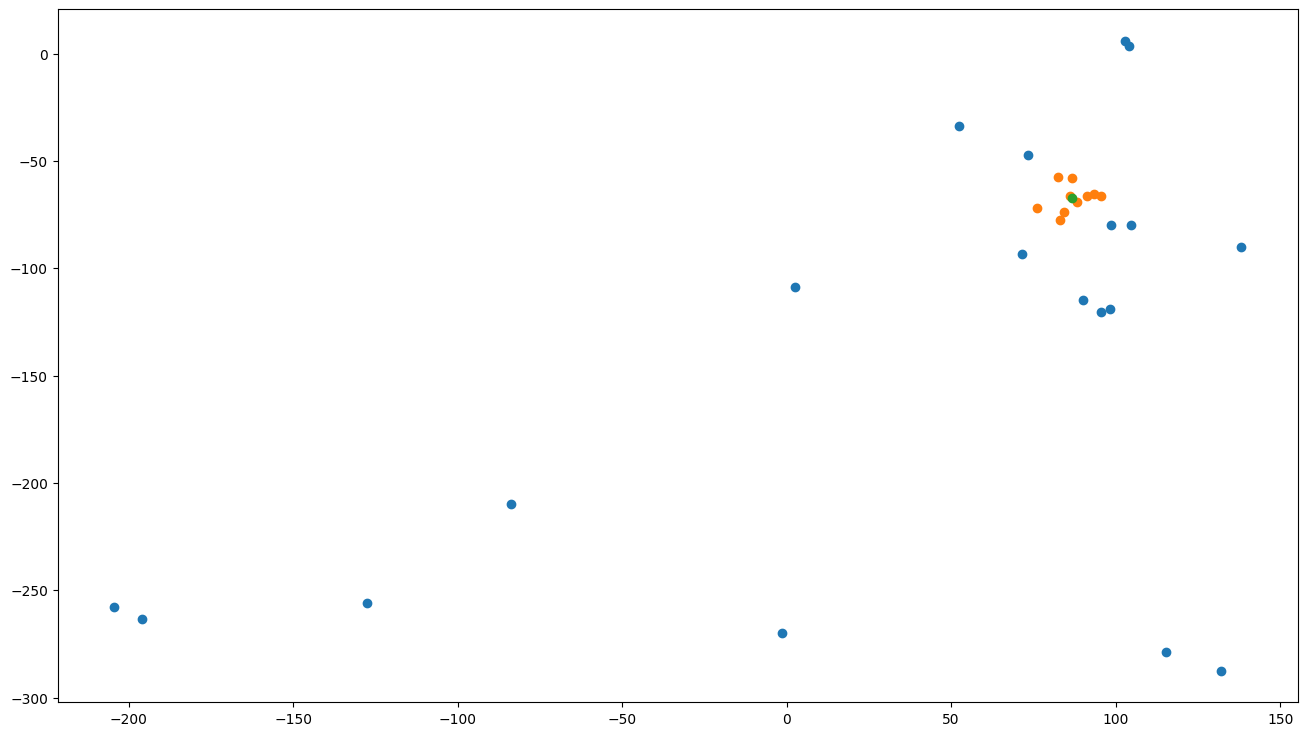

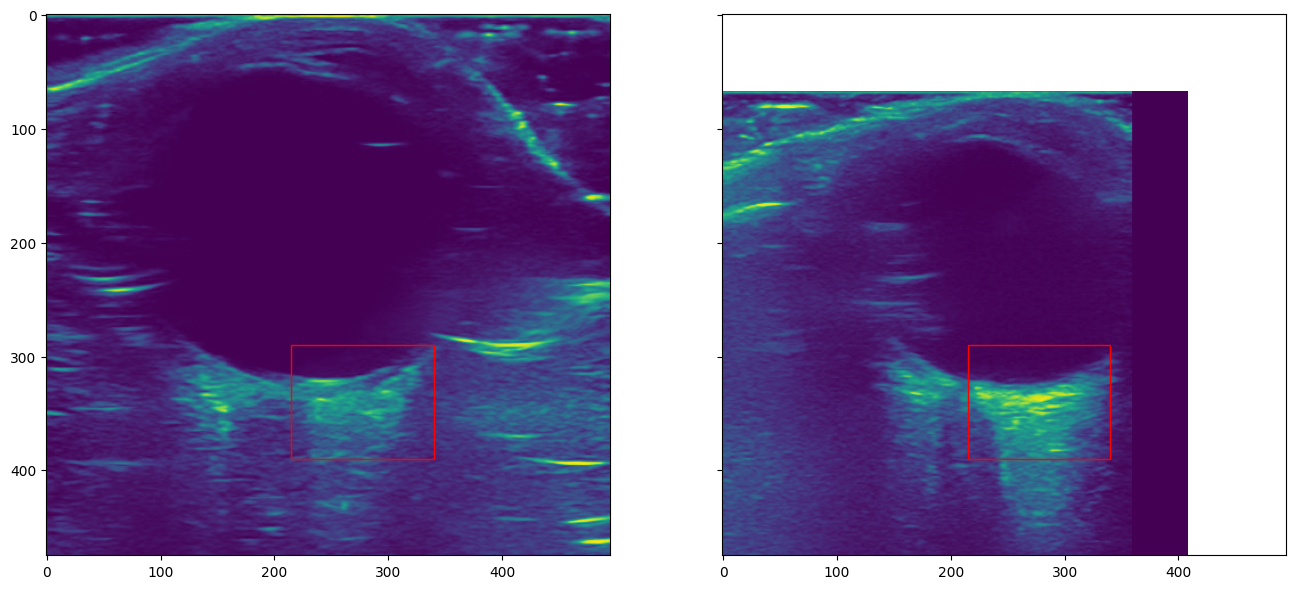

In [11]:
img_no = 173
img_no = 109
img_no = 105
#img_no = 43
#img_no = 3
offset, deltas, selection, match_image = alignImages(cv_images[0], cv_images[img_no])

deltas = deltas[np.where((deltas[:,0] > -crop_left) & (deltas[:,0] < 200) & (deltas[:,1] > -crop_top) & (deltas[:,1] < 80))]

print(offset)

fig, ax = plt.subplots()
ax.imshow(match_image)

model = DBSCAN(eps=10, min_samples=5)
yhat = model.fit_predict(deltas)
clusters = np.unique(yhat)
fig, ax = plt.subplots()
for cluster in [clusters[0], 0]:
    print(cluster)
    cluster_points = np.where(yhat == cluster)
    ax.scatter(deltas[cluster_points,0], deltas[cluster_points,1])
    offset = np.average(deltas[np.where(yhat == cluster)],0)
ax.scatter(offset[0], offset[1])

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
ax[1].imshow(cv_images[img_no], extent = (-offset[0], -offset[0] + img_width, -offset[1] + img_height, -offset[1]))
rect2 = patches.Rectangle((crop_left, crop_top), crop_width, crop_height, linewidth=1, edgecolor='r', facecolor='none')
#rect2 = patches.Rectangle((crop_left-offset[0], crop_top-offset[1]), crop_width, crop_height, linewidth=1, edgecolor='r', facecolor='none')
ax[1].add_patch(rect2)
ax[0].imshow(cv_images[0])
rect1 = patches.Rectangle((crop_left, crop_top), crop_width, crop_height, linewidth=1, edgecolor='r', facecolor='none')
ax[0].add_patch(rect1)

/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/workspaces/ONSD_Ex

i=14 offset=array([63.93400879, 60.88247681])


/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/workspaces/ONSD_Ex

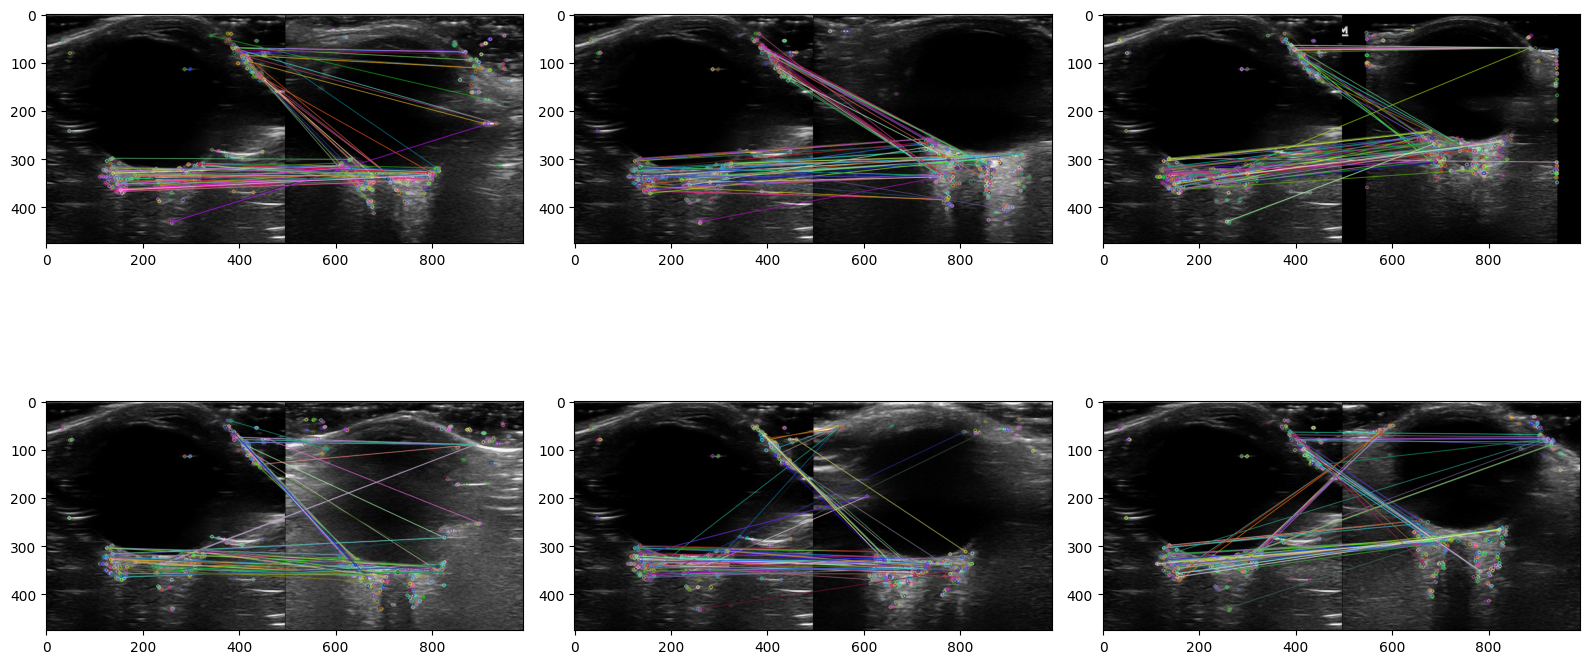

In [12]:
offsets = [np.zeros((2))]    # x, y
deltas = [np.zeros((1, 2))]
selections = [(0)]
match_images = []
for i, image in enumerate(cv_images[1:]):
    offset, delta, selection, match_image = alignImages(cv_images[0], image)
    if offset[1] > 60:
        print(f"i={i+1} {offset=}")
    offsets.append(offset)
    deltas.append(delta)
    selections.append(selection)
    match_images.append(match_image)

half_width = width#//2
fig, ax = plt.subplots(height, half_width)
for i in range(height * half_width):
    ax[i // half_width, i % half_width].imshow(match_images[i])
plt.tight_layout()

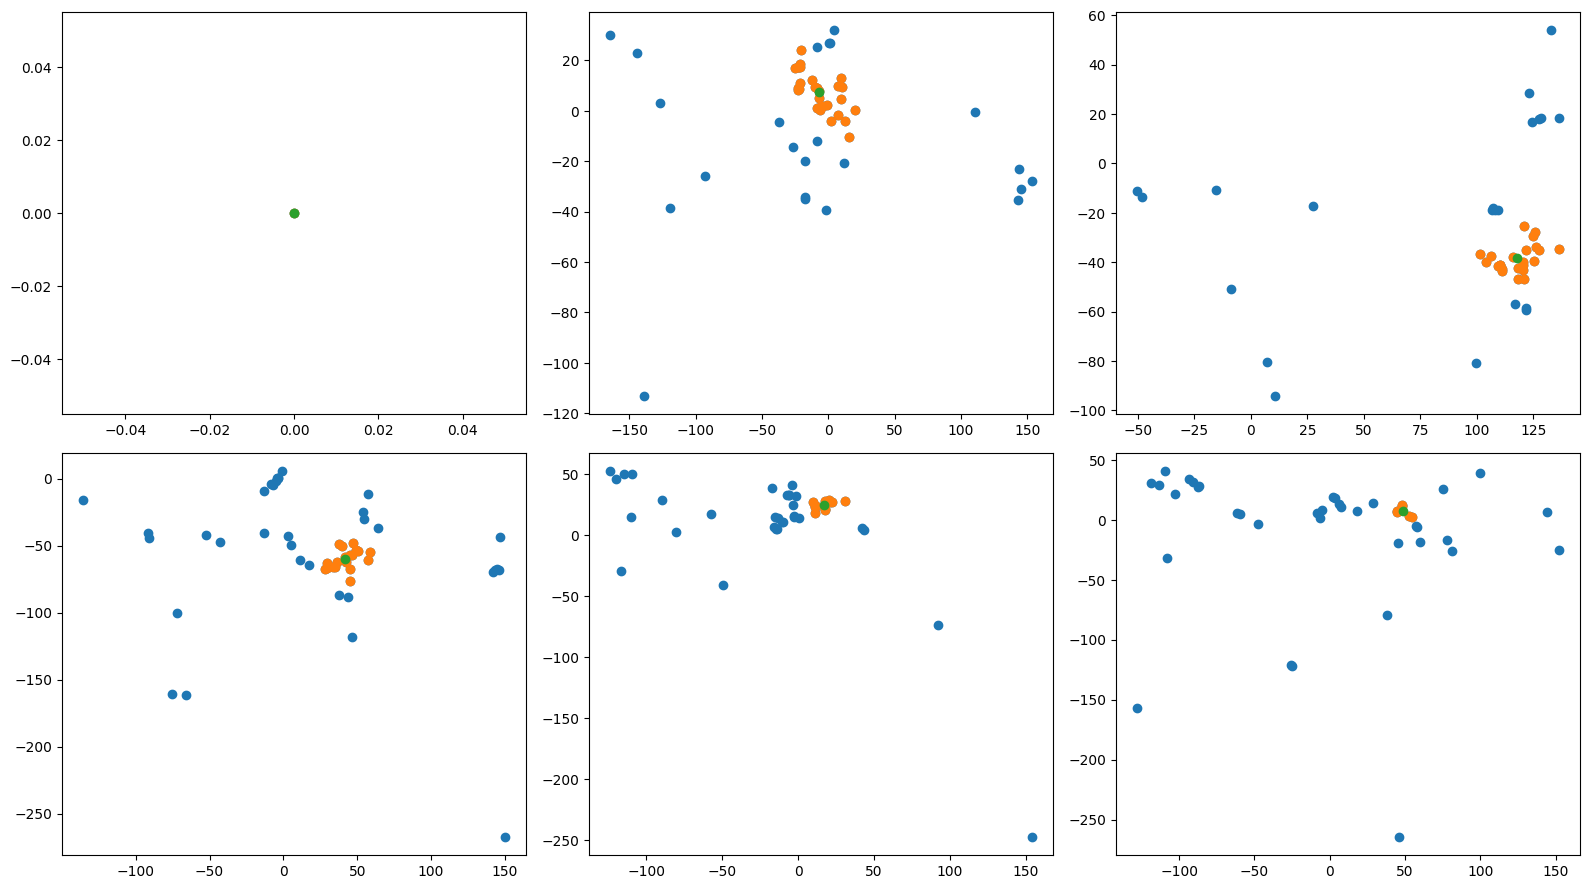

In [13]:
half_width = width# - 1
fig, ax = plt.subplots(height, half_width)
for i in range(height * half_width):
    ax[i // half_width, i % half_width].scatter(deltas[i][:,0],deltas[i][:,1])
    ax[i // half_width, i % half_width].scatter(deltas[i][selections[i],0],deltas[i][selections[i],1])
    ax[i // half_width, i % half_width].scatter(offsets[i][0], offsets[i][1])
plt.tight_layout()

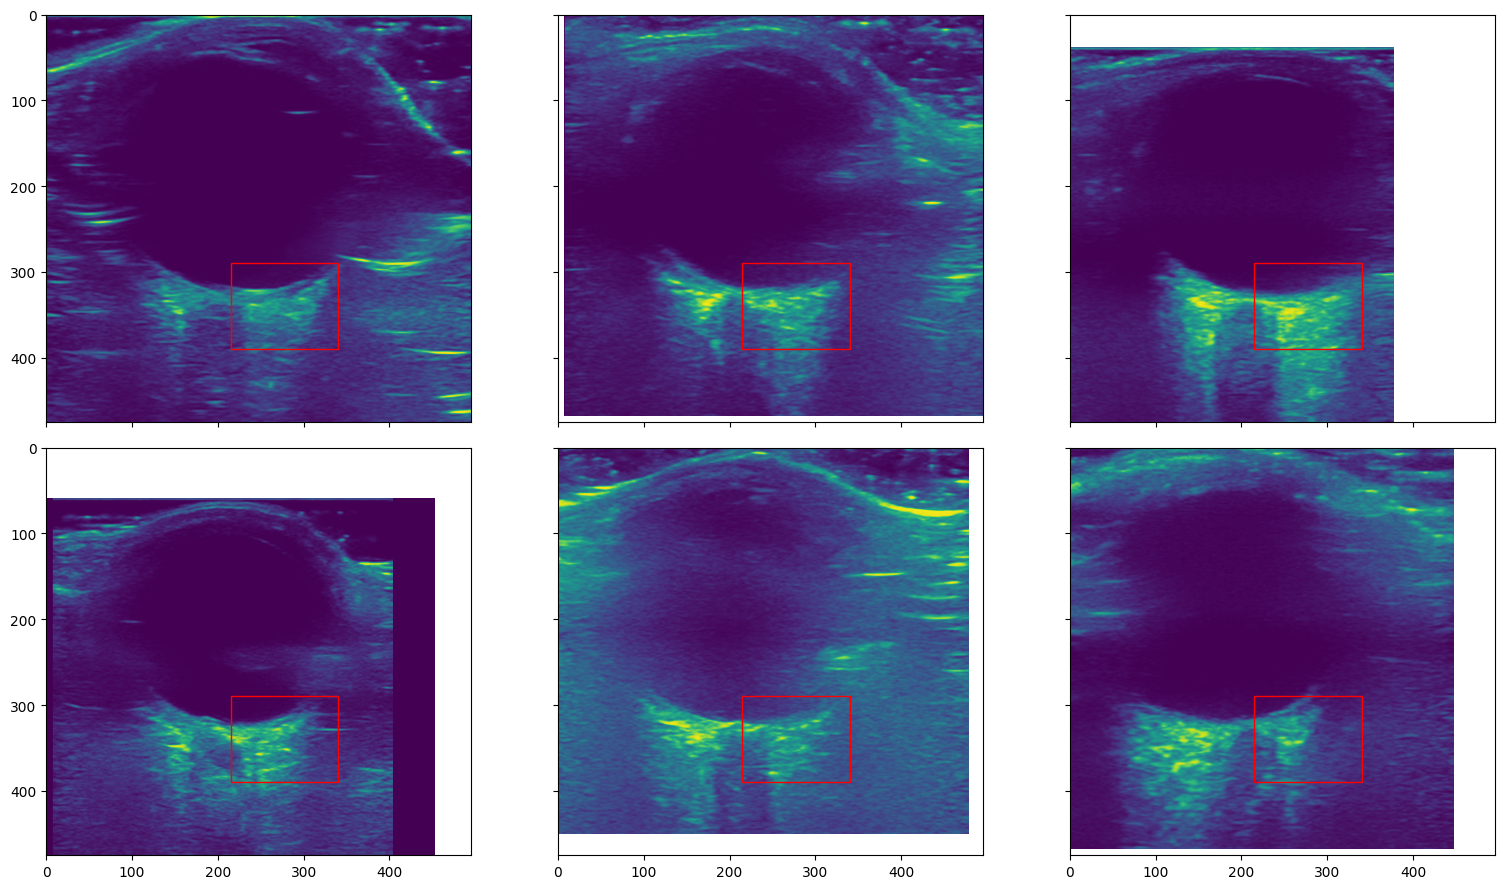

In [14]:
fig, ax = plt.subplots(height, width, sharex=True, sharey=True)

# Display the first images
for i in reversed(range(height * width)):
    offset_left, offset_top = offsets[i]
    offset_left = -offset_left
    offset_top = -offset_top
    offsets[i][0], offsets[i][1]
    ax[i // width, i % width].imshow(cv_images[i], extent = (offset_left, offset_left + img_width, offset_top + img_height, offset_top))
    rect = patches.Rectangle((crop_left, crop_top), crop_width, crop_height, linewidth=1, edgecolor='r', facecolor='none')
    ax[i // width, i % width].add_patch(rect)
plt.tight_layout()

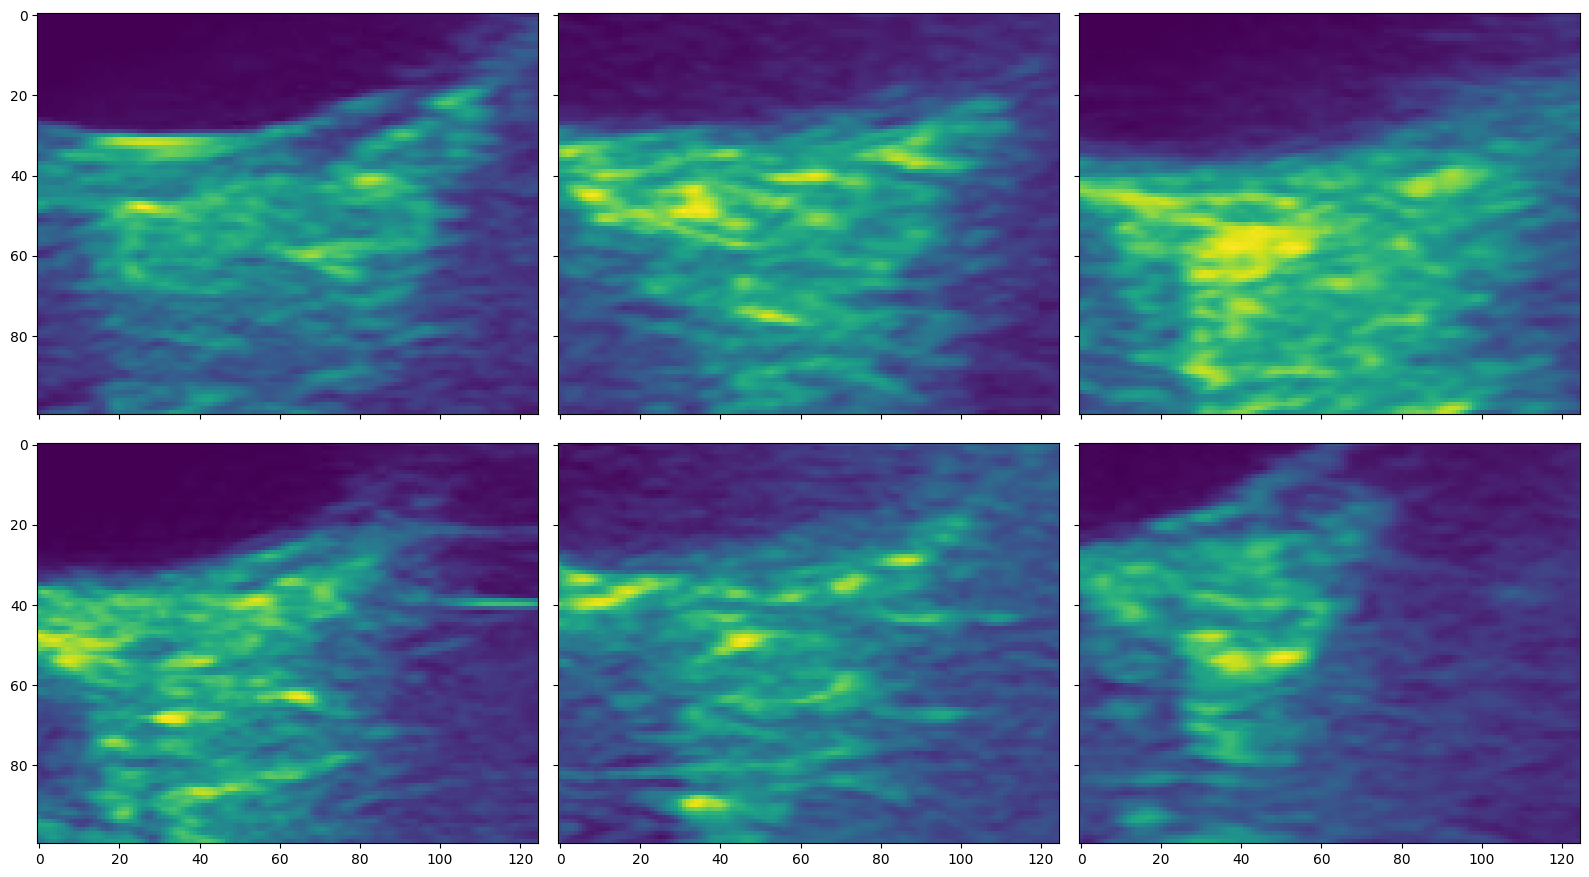

In [15]:
fig, ax = plt.subplots(height, width, sharex=True, sharey=True)

# Display the first images
for i in range(height * width):
    offset_left, offset_top = offsets[i]
    cropped_top = int(crop_top + offset_top)
    cropped_bottom = int(crop_bottom + offset_top)
    cropped_left = int(crop_left + offset_left)
    cropped_right = int(crop_right + offset_left)
    ax[i // width, i % width].imshow(cv_images[i][cropped_top:cropped_bottom,cropped_left:cropped_right])
    #ax[i // width, i % width].imshow(cv_images[i], extent = (offset_left, offset_left + img_width, offset_top + img_height, offset_top))
plt.tight_layout()

In [16]:
# Prepare image dataset
image_dataset = np.zeros((len(cv_images), crop_height, crop_width), dtype=np.uint8)
#print(crop_height, crop_width)
#print(crop_top - crop_bottom)
for i, image in enumerate(cv_images):
    offset_left, offset_top = offsets[i]
    cropped_top = int(crop_top + offset_top)
    cropped_bottom = int(crop_bottom + offset_top)
    cropped_left = int(crop_left + offset_left)
    cropped_right = int(crop_right + offset_left)
    #print(i, cropped_bottom - cropped_top, cropped_right - cropped_left)
    cropped_image = image[cropped_top:cropped_bottom,cropped_left:cropped_right]
    #print(image_dataset[i].shape, cropped_image.shape)
    image_dataset[i] = cropped_image

image_dataset.shape

ValueError: cannot convert float NaN to integer

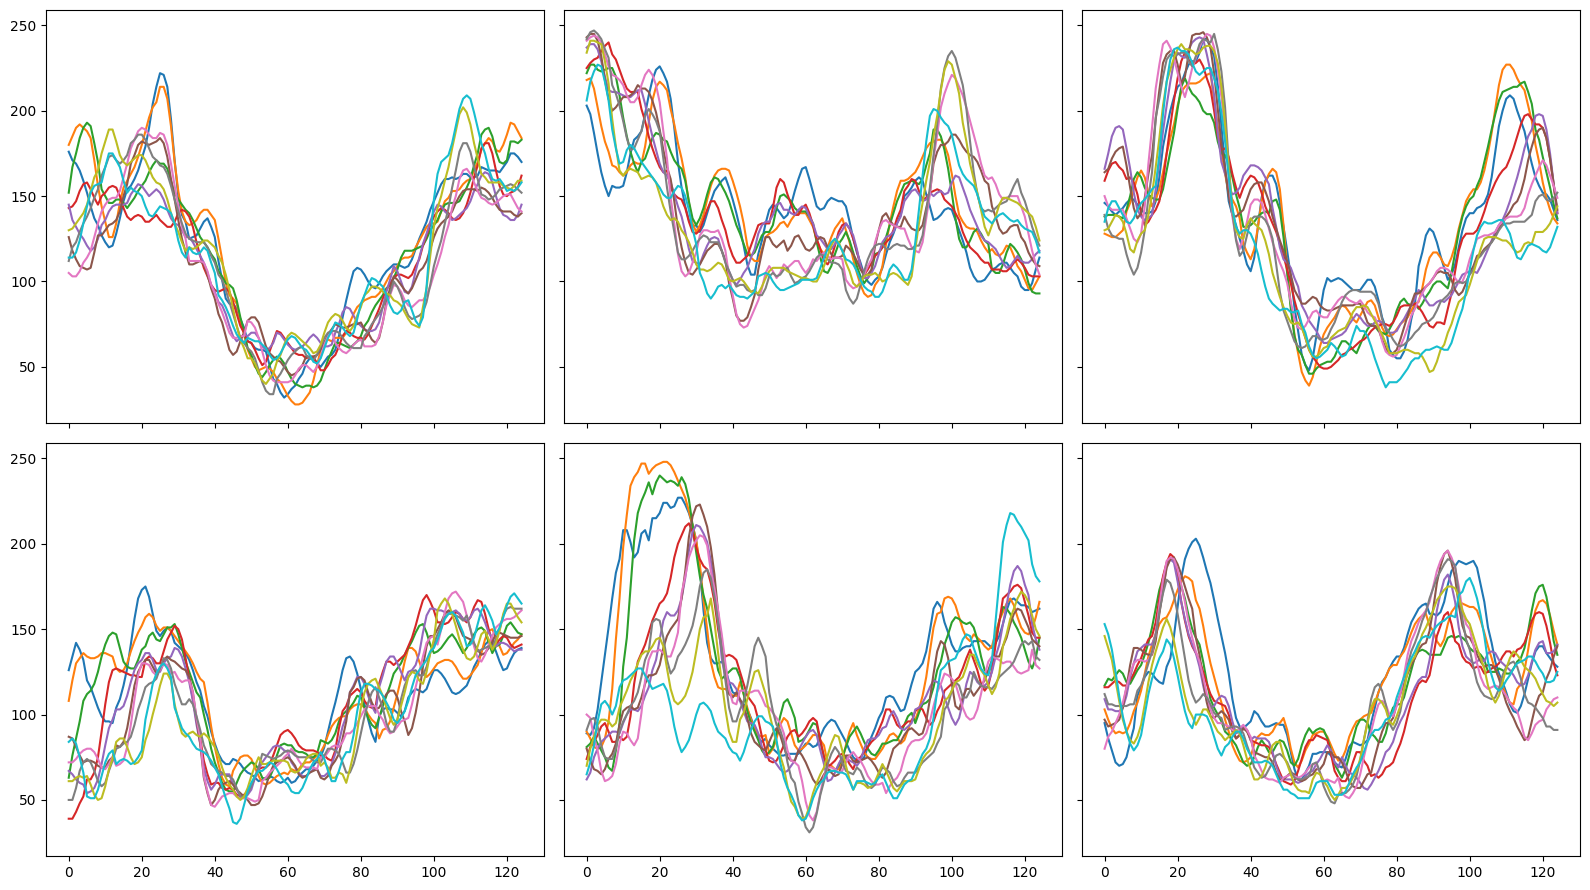

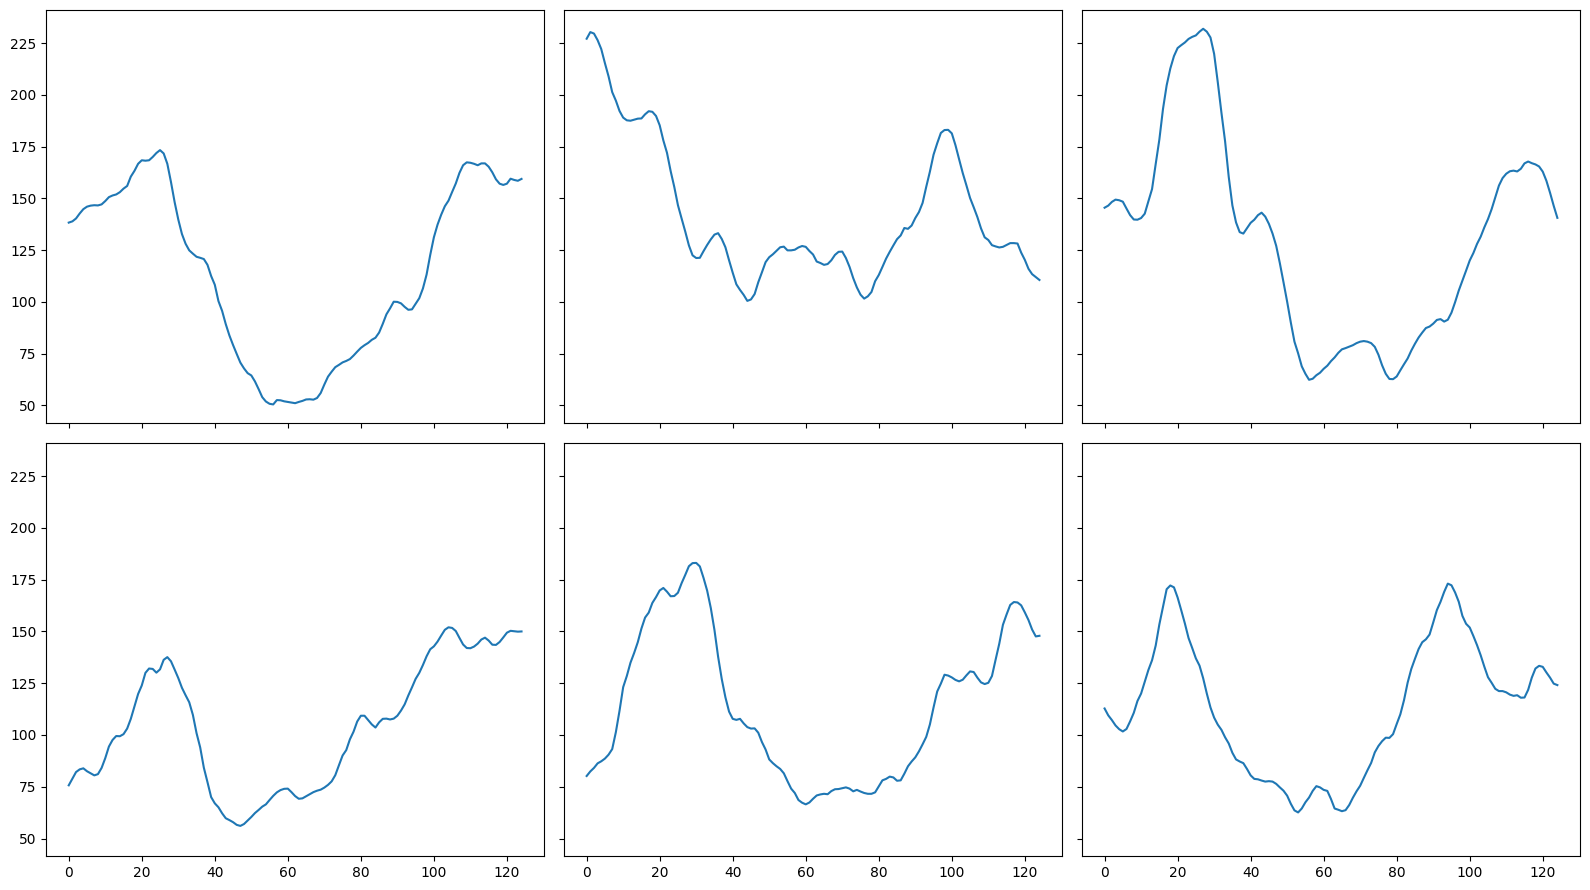

In [ ]:
# Plot transects over the region of interest
fig, ax = plt.subplots(height, width, sharex=True, sharey=True)
#img_width = right - left
#img_height = bottom - top
#crop_top = 295
#crop_bottom = crop_top + 150
#crop_left = 200
#crop_right = 350

profiles = []
# Display the first images
for i in range(height * width):
    offset_left, offset_top = offsets[i]
    cropped_top = int(crop_top + offset_top)
    cropped_bottom = int(crop_bottom + offset_top)
    cropped_left = int(crop_left + offset_left)
    cropped_right = int(crop_right + offset_left)
    offset = 30
    #print(cv_images[i][cropped_top+30,cropped_left:cropped_right])
    #cv_images[i][cropped_top+30,cropped_left:cropped_right]
    section = np.swapaxes(cv_images[i][cropped_top+25:cropped_top+35,cropped_left:cropped_right], 0, 1)
    #profile = np.median(section, axis=1)
    profile = np.average(section, axis=1)
    profiles.append(profile)
    ax[i // width, i % width].plot(section)
    #ax[i // width, i % width].plot(profile)
plt.tight_layout()

fig, ax = plt.subplots(height, width, sharex=True, sharey=True)
for i in range(height * width):
    ax[i // width, i % width].plot(profiles[i])
plt.tight_layout()

Mapping ONSD measurements to images to create labels

In [ ]:
import pandas as pd
import os

# Load the DataFrame from the Excel file
excel_file = './Meta_pic.xlsx'
df = pd.read_excel(excel_file)

# Convert necessary columns to strings and create a label column following the naming convention
df['label'] = df['record_id'].astype(str) + '_image_data_' + df['redcap_repeat_instance'].astype(str) + '_raw_image.jpg'

# Now let's proceed to match and rename the images
documents_dir = './documents'  # Assuming this is your correct directory path

# Iterate over the DataFrame to match, rename images and create an ONSD mapping dictionary
image_onsd_mapping = {}
for index, row in df.iterrows():
    image_name_to_look_for = row['label']
    onsd_value = row['onsd']
    image_path = os.path.join(documents_dir, image_name_to_look_for)

    if os.path.exists(image_path):
        image_onsd_mapping[image_name_to_look_for] = onsd_value
    else:
        print(f"No matching file found for label: {image_name_to_look_for}")

# Display the ONSD mapping
for image_name, onsd_value in image_onsd_mapping.items():
    print(f"{image_name}: {onsd_value}")


MMED-002_image_data_1_raw_image.jpg: 5
MMED-002_image_data_2_raw_image.jpg: 5
MMED-003_image_data_1_raw_image.jpg: 5
MMED-004_image_data_1_raw_image.jpg: 5
MMED-004_image_data_2_raw_image.jpg: 5
MMED-005_image_data_1_raw_image.jpg: 5
MMED-005_image_data_2_raw_image.jpg: 4
MMED-006_image_data_1_raw_image.jpg: 5
MMED-006_image_data_2_raw_image.jpg: 5
MMED-007_image_data_1_raw_image.jpg: 4
MMED-007_image_data_2_raw_image.jpg: 5
MMED-008_image_data_1_raw_image.jpg: 5
MMED-008_image_data_2_raw_image.jpg: 5
MMED-009_image_data_1_raw_image.jpg: 4
MMED-010_image_data_1_raw_image.jpg: 5
MMED-010_image_data_2_raw_image.jpg: 6
MMED-011_image_data_1_raw_image.jpg: 4
MMED-011_image_data_2_raw_image.jpg: 4
MMED-012_image_data_1_raw_image.jpg: 4
MMED-012_image_data_2_raw_image.jpg: 4
MMED-013_image_data_1_raw_image.jpg: 4
MMED-013_image_data_2_raw_image.jpg: 5
MMED-014_image_data_1_raw_image.jpg: 5
MMED-014_image_data_2_raw_image.jpg: 5
MMED-015_image_data_1_raw_image.jpg: 5
MMED-015_image_data_2_raw

Importing Libaries for simple CNN attempt for regression task of measuring ONSD

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import os
from PIL import Image


2024-05-08 22:00:40.624836: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 22:00:40.625526: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 22:00:40.644601: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-08 22:00:40.740510: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load and split processed image data

In [ ]:
import pandas as pd
import os
from PIL import Image
import numpy as np

# Correct base directory for your processed images
base_dir = r"./documents/processed_images"

# Assuming you have 'image_measurements.csv' in the same directory as your processed images
csv_file = os.path.join(base_dir, 'image_measurements.csv')
df = pd.read_csv(csv_file)

# Function to load images based on the corrected path
def load_images(df, base_dir):
    images = []
    for _, row in df.iterrows():
        image_path = os.path.join(base_dir, row['image_filename'])
        try:
            with Image.open(image_path) as img:
                img = img.resize((128, 128))  # Resize for uniformity
                img_array = np.array(img)
                images.append(img_array)
        except FileNotFoundError:
            print(f"File not found: {image_path}")
    return np.array(images)

images = load_images(df, base_dir)
onsd_measurements = df['onsd_measurement'].values

# Normalize images
images = images / 255.0

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(image_dataset, onsd_measurements, test_size=0.2, random_state=42)


In [ ]:
# Reshape image to have a single array per pixel to indicate one channel
image_dataset = image_dataset.reshape(image_dataset.shape[:3] + (1,))

Simple CNN model architecture

In [ ]:
def build_model():
    model = Sequential([
#        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        Conv2D(32, (3, 3), activation='relu', input_shape=(100, 125, 1)),
        MaxPooling2D((3, 3)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1)  # Single output node for regression
    ])
    return model


In [ ]:
model = build_model()
model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])  # MSE is a common loss for regression


2024-05-08 22:00:44.514664: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-08 22:00:44.640499: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-08 22:00:44.640588: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-08 22:00:44.681622: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-08 22:00:44.681687: I external/local_xla/xla/stream_executor

In [ ]:
history = model.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test))


Epoch 1/25


2024-05-08 22:00:46.566450: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-05-08 22:00:49.042643: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f5e4b006b60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-08 22:00:49.042758: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2024-05-08 22:00:49.053776: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1715202049.165153   30074 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6/6 [==============================] - 6s 214ms/step - loss: 599.5843 - mae: 18.3041 - val_loss: 45.6361 - val_mae: 6.7268
Epoch 2/25
6/6 [==============================] - 0s 14ms/step - loss: 24.6257 - mae: 4.1462 - val_loss: 1.8858 - val_mae: 1.1731
Epoch 3/25
6/6 [==============================] - 0s 13ms/step - loss: 3.4767 - mae: 1.5186 - val_loss: 2.9348 - val_mae: 1.6341
Epoch 4/25
6/6 [==============================] - 0s 12ms/step - loss: 3.9114 - mae: 1.6994 - val_loss: 0.9770 - val_mae: 0.6381
Epoch 5/25
6/6 [==============================] - 0s 13ms/step - loss: 3.2694 - mae: 1.4288 - val_loss: 1.0016 - val_mae: 0.8253
Epoch 6/25
6/6 [==============================] - 0s 12ms/step - loss: 2.5406 - mae: 1.2873 - val_loss: 0.6361 - val_mae: 0.5732
Epoch 7/25
6/6 [==============================] - 0s 11ms/step - loss: 2.7539 - mae: 1.3292 - val_loss: 1.0014 - val_mae: 0.8373
Epoch 8/25
6/6 [==============================] - 0s 12ms/step - loss: 2.6859 - mae: 1.3777 - val_loss

In [ ]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae}")


2/2 [==============================] - 0s 5ms/step - loss: 0.7715 - mae: 0.6721
Test MAE: 0.6720727682113647


In [ ]:
# Make predictions
predictions = model.predict(X_test)


2/2 [==============================] - 0s 3ms/step


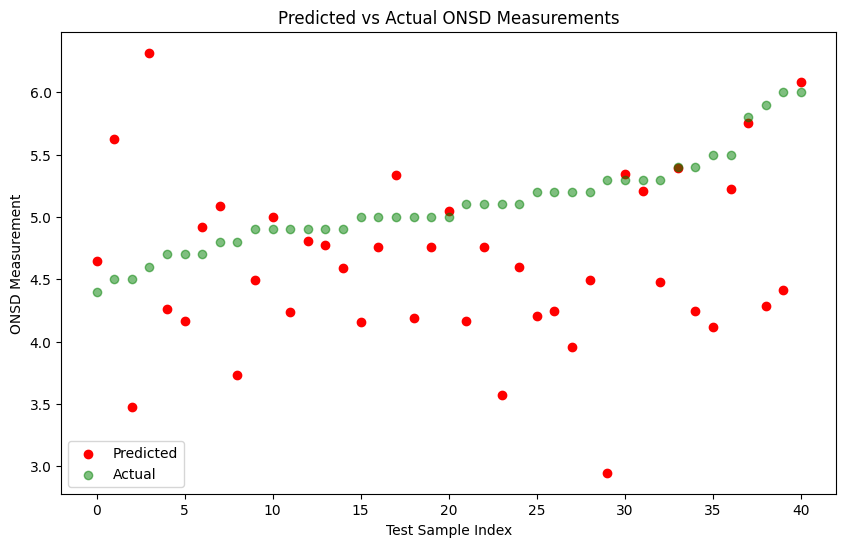

In [ ]:
import matplotlib.pyplot as plt

order = y_test.argsort(axis=None).reshape(predictions.shape)
sorted_predictions = predictions.ravel()[order]
sorted_data = y_test.ravel()[order]

plt.figure(figsize=(10, 6))
plt.scatter(range(len(predictions)), sorted_predictions, color='r', label='Predicted')
plt.scatter(range(len(y_test)), sorted_data, color='g', alpha=0.5, label='Actual')
plt.title('Predicted vs Actual ONSD Measurements')
plt.xlabel('Test Sample Index')
plt.ylabel('ONSD Measurement')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Square Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 0.6720727734449433
Root Mean Square Error (RMSE): 0.87836988804374


[[6.         4.41726732]
 [4.9        4.23988104]
 [4.9        4.77606916]
 [5.4        4.24354601]
 [4.9        4.59367609]
 [4.8        5.09123659]
 [5.9        4.28494596]
 [5.2        4.49575949]
 [4.7        4.25874424]
 [5.         4.75808716]]


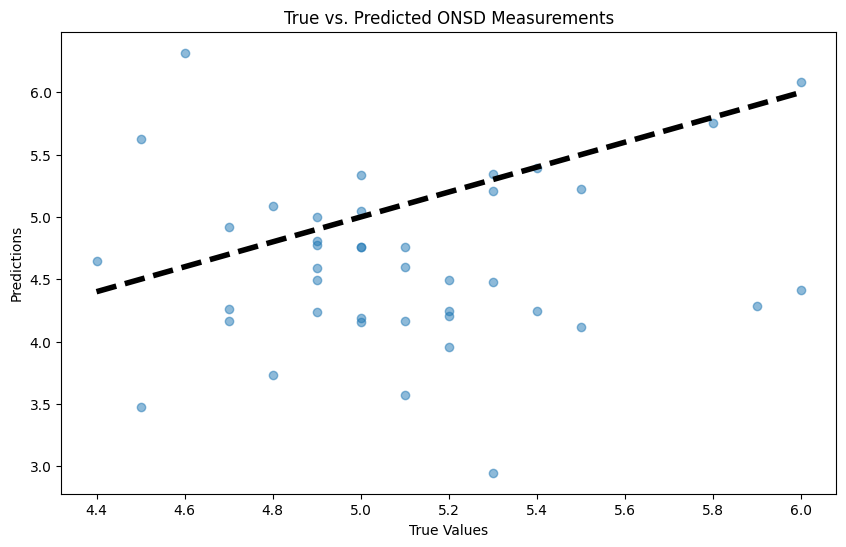

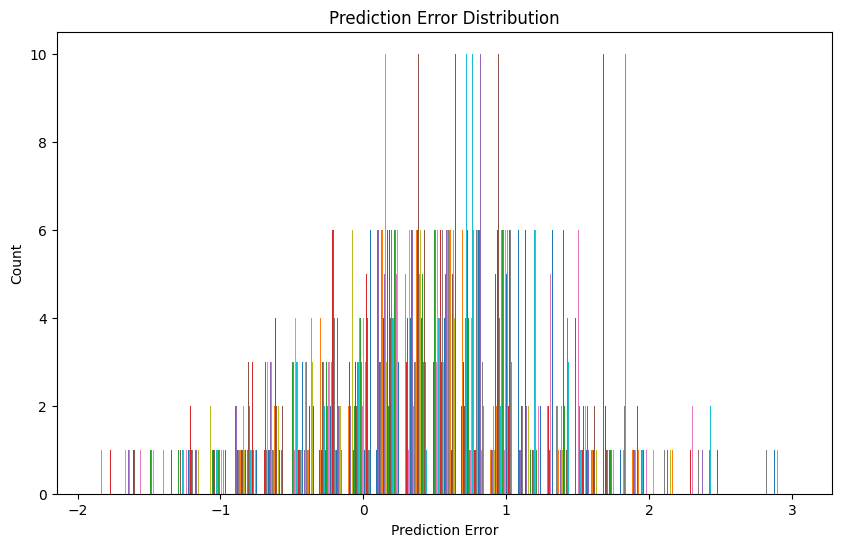

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'predictions' is a numpy array of your model's predicted ONSD measurements
# and 'y_test' is the true ONSD measurements

# Compare predictions with actual values
comparison = np.column_stack((y_test, predictions))

# Print the first few comparisons to check
print(comparison[:10])

# Plotting the true vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Diagonal line for reference
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted ONSD Measurements')
plt.show()

# Plotting the error distribution
errors = y_test - predictions
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=25)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Prediction Error Distribution')
plt.show()


Trying a different architecture to see if it improves performance

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def build_enhanced_model(input_shape=(100, 125, 1)):
    model = Sequential()

    # First Conv Block
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Second Conv Block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Third Conv Block
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))

    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1))  # Output layer for regression

    return model


Building what I hope to be an enhanced model 

In [ ]:
model = build_enhanced_model()
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Now you would train your model, perhaps with more epochs or different batch sizes
model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))


Epoch 1/50


2024-05-08 22:00:56.264409: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


6/6 [==============================] - 4s 212ms/step - loss: 30.1723 - mae: 5.1842 - val_loss: 255.2575 - val_mae: 15.5281
Epoch 2/50
6/6 [==============================] - 0s 27ms/step - loss: 27.0841 - mae: 4.9283 - val_loss: 17.1019 - val_mae: 3.5810
Epoch 3/50
6/6 [==============================] - 0s 22ms/step - loss: 25.7121 - mae: 4.9271 - val_loss: 5.7792 - val_mae: 1.9595
Epoch 4/50
6/6 [==============================] - 0s 21ms/step - loss: 25.0461 - mae: 4.8585 - val_loss: 6.9456 - val_mae: 2.2981
Epoch 5/50
6/6 [==============================] - 0s 22ms/step - loss: 26.0484 - mae: 4.9193 - val_loss: 14.0480 - val_mae: 3.4726
Epoch 6/50
6/6 [==============================] - 0s 29ms/step - loss: 24.0050 - mae: 4.7125 - val_loss: 30.9168 - val_mae: 5.4079
Epoch 7/50
6/6 [==============================] - 0s 25ms/step - loss: 22.8385 - mae: 4.5975 - val_loss: 44.3031 - val_mae: 6.5042
Epoch 8/50
6/6 [==============================] - 0s 30ms/step - loss: 22.7527 - mae: 4.5713 

2/2 [==============================] - 0s 4ms/step
Mean Absolute Error (MAE): 5.3244994791542615
Mean Squared Error (MSE): 179.50442236441995
Root Mean Squared Error (RMSE): 13.397926047132069


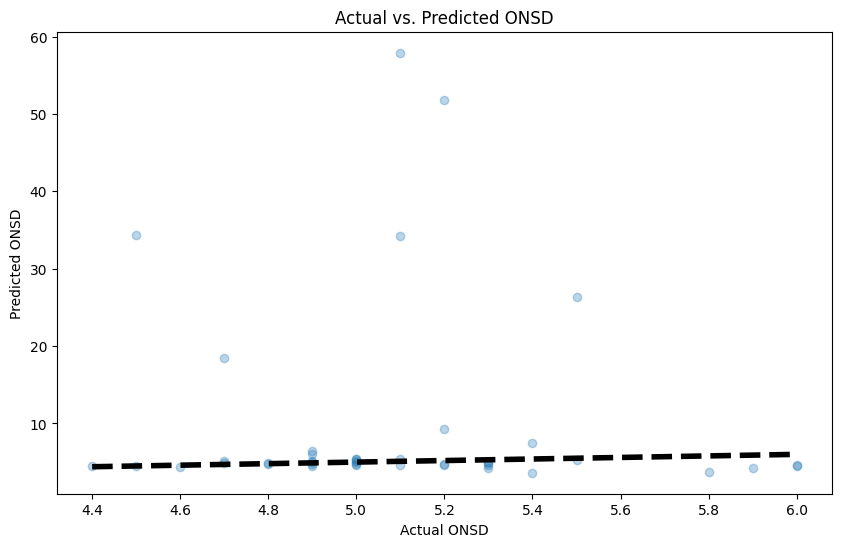

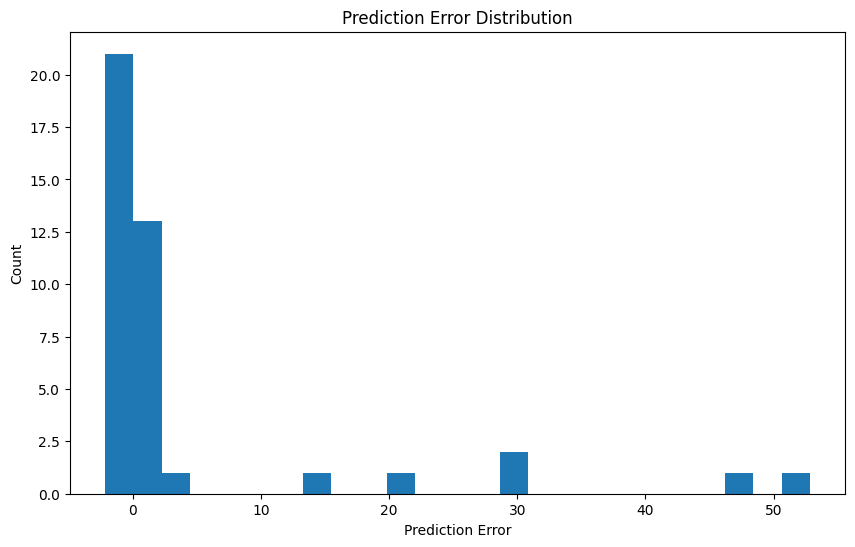

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Assuming 'X_test' and 'y_test' are your test datasets

# Make predictions on the test set
predictions = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)  # RMSE is just the square root of MSE

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plotting Actual vs. Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Diagonal line
plt.xlabel('Actual ONSD')
plt.ylabel('Predicted ONSD')
plt.title('Actual vs. Predicted ONSD')
plt.show()

# Plotting the error distribution
errors = predictions.flatten() - y_test
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=25)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Prediction Error Distribution')
plt.show()


In [ ]:
# Assuming 'predictions' is a numpy array with the predicted ONSD values
# And 'y_test' is the actual ONSD measurements from the test set

# Convert predictions to a 1D array if it's not already
predictions = predictions.flatten()

# Create a DataFrame for a cleaner display
comparison_df = pd.DataFrame({'Actual ONSD': y_test, 'Predicted ONSD': predictions})

# Add a column for absolute error
comparison_df['Absolute Error'] = np.abs(comparison_df['Actual ONSD'] - comparison_df['Predicted ONSD'])

# Display several examples
print(comparison_df.head(10))


   Actual ONSD  Predicted ONSD  Absolute Error
0          6.0        4.464065        1.535935
1          4.9        6.029334        1.129334
2          4.9        4.444532        0.455468
3          5.4        7.427076        2.027076
4          4.9        5.186278        0.286278
5          4.8        4.900393        0.100393
6          5.9        4.238082        1.661918
7          5.2        4.789043        0.410957
8          4.7       18.505386       13.805386
9          5.0        4.752312        0.247688


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Compile model with a smaller learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

# Add early stopping to halt training when validation loss increases
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model with early stopping
history = model.fit(
    X_train, y_train, 
    batch_size=32, 
    epochs=50, 
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)


Epoch 1/50
6/6 [==============================] - 2s 67ms/step - loss: 2.8662 - mae: 1.3213 - val_loss: 11.5232 - val_mae: 1.6158
Epoch 2/50
6/6 [==============================] - 0s 32ms/step - loss: 3.0329 - mae: 1.3008 - val_loss: 6.6125 - val_mae: 1.3034
Epoch 3/50
6/6 [==============================] - 0s 28ms/step - loss: 2.5523 - mae: 1.2526 - val_loss: 4.9451 - val_mae: 1.1694
Epoch 4/50
6/6 [==============================] - 0s 28ms/step - loss: 3.1652 - mae: 1.3608 - val_loss: 3.5346 - val_mae: 1.0350
Epoch 5/50
6/6 [==============================] - 0s 26ms/step - loss: 3.3479 - mae: 1.4327 - val_loss: 2.9024 - val_mae: 0.9748
Epoch 6/50
6/6 [==============================] - 0s 24ms/step - loss: 2.0899 - mae: 1.0680 - val_loss: 2.8326 - val_mae: 0.9659
Epoch 7/50
6/6 [==============================] - 0s 22ms/step - loss: 2.8032 - mae: 1.3037 - val_loss: 2.9912 - val_mae: 0.9794
Epoch 8/50
6/6 [==============================] - 0s 22ms/step - loss: 3.0119 - mae: 1.2452 - va

2/2 [==============================] - 0s 5ms/step
Mean Absolute Error (MAE): 0.9659087785860386
Mean Squared Error (MSE): 2.8326429160707054
Root Mean Squared Error (RMSE): 1.683045726078381


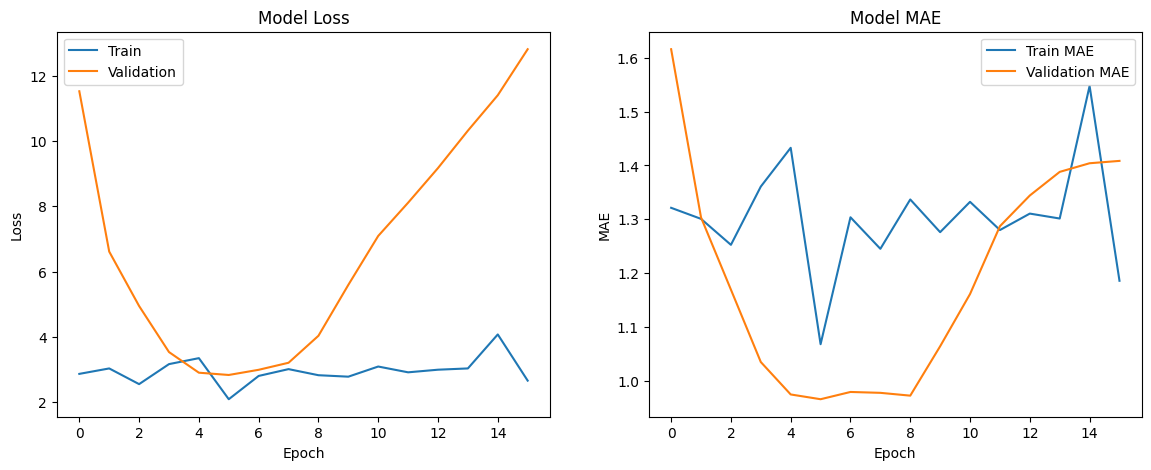

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions
predictions = model.predict(X_test).flatten()

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot the training history
plt.figure(figsize=(14, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation MAE values
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()
